In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d
from HST_Extract_Funcs import CreateSubExps, WavelengthSolution  # Used to pull image data

In [2]:
# loading in the broadband values from the image extraction notebook
exfile = np.load('reduced_data_dict.npz', allow_pickle=True)
exdict = exfile['dictionary'].item()

# we're only doing visit 3 for now
bbflux_orbit1 = np.asarray(exdict['visit3']['orbit1']['broadband'])
bbflux_orbit2 = np.asarray(exdict['visit3']['orbit2']['broadband'])
bbflux_orbit3 = np.asarray(exdict['visit3']['orbit3']['broadband'])
bbflux_orbit4 = np.asarray(exdict['visit3']['orbit4']['broadband'])

bbunc_orbit1 = np.asarray(exdict['visit3']['orbit1']['broadband_uncs'])
bbunc_orbit2 = np.asarray(exdict['visit3']['orbit2']['broadband_uncs'])
bbunc_orbit3 = np.asarray(exdict['visit3']['orbit3']['broadband_uncs'])
bbunc_orbit4 = np.asarray(exdict['visit3']['orbit4']['broadband_uncs'])

In [3]:
# I need to loop through all the images, get the times of each of their sub-exposures
#   and then average them to get the image's time

time_orbit1 = np.zeros(len(bbflux_orbit1))
time_orbit2 = np.zeros(len(bbflux_orbit2))
time_orbit3 = np.zeros(len(bbflux_orbit3))
time_orbit4 = np.zeros(len(bbflux_orbit4))

scandir_orbit1 = np.zeros(len(bbflux_orbit1))
scandir_orbit2 = np.zeros(len(bbflux_orbit2))
scandir_orbit3 = np.zeros(len(bbflux_orbit3))
scandir_orbit4 = np.zeros(len(bbflux_orbit4))

# First loading in the data paths to the image files
FPload = np.load('FilePaths.npz', allow_pickle=True)
datapaths = FPload['filedict'].item()   # dictionary containing paths to the image files
del FPload

for orbit in datapaths['visit3']:
    # Going through each orbit in the visit
    Nimages = len(datapaths['visit3'][orbit]['grism'])
    orbits_imagetimes = np.zeros(Nimages)
    directimage_path = datapaths['visit3'][orbit]['direct']
    wavesolution = WavelengthSolution(directimage_path)
    
    for image in range(Nimages):

        subexposure_details = CreateSubExps(datapaths['visit3'][orbit]['grism'][image], wavesolution)
        subexposure_times = subexposure_details[1]
        image_scandir = subexposure_details[4]
        image_time = np.median(subexposure_times)
        
        if orbit == 'orbit1':
            time_orbit1[image] = image_time
            scandir_orbit1[image] = image_scandir
        elif orbit == 'orbit2':
            time_orbit2[image] = image_time
            scandir_orbit2[image] = image_scandir
        elif orbit == 'orbit3':
            time_orbit3[image] = image_time
            scandir_orbit3[image] = image_scandir
        elif orbit == 'orbit4':
            time_orbit4[image] = image_time
            scandir_orbit4[image] = image_scandir            


In [4]:
scan0_orbit1_idxs, scan1_orbit1_idxs = np.where(scandir_orbit1 == 0)[0], np.where(scandir_orbit1 == 1)[0]
scan0_orbit2_idxs, scan1_orbit2_idxs = np.where(scandir_orbit2 == 0)[0], np.where(scandir_orbit2 == 1)[0]
scan0_orbit3_idxs, scan1_orbit3_idxs = np.where(scandir_orbit3 == 0)[0], np.where(scandir_orbit3 == 1)[0]
scan0_orbit4_idxs, scan1_orbit4_idxs = np.where(scandir_orbit4 == 0)[0], np.where(scandir_orbit4 == 1)[0]

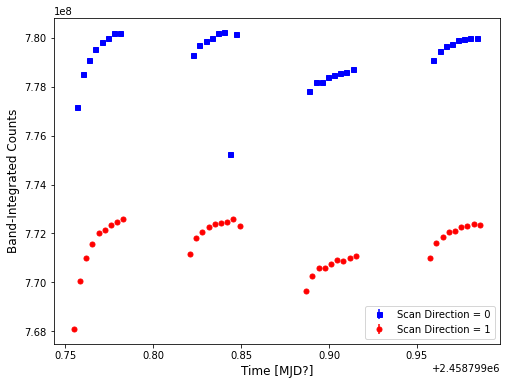

In [5]:
# Plotting our raw broadband light curve
fig, ax = plt.subplots(figsize=(8,6))

# Plotting orbit 1 values
ax.errorbar(time_orbit1[scan0_orbit1_idxs], bbflux_orbit1[scan0_orbit1_idxs], yerr=bbunc_orbit1[scan0_orbit1_idxs], 
           c='blue', marker='s', ms=5, ls='None')
ax.errorbar(time_orbit1[scan1_orbit1_idxs], bbflux_orbit1[scan1_orbit1_idxs], yerr=bbunc_orbit1[scan1_orbit1_idxs], 
           c='red', marker='o', ms=5, ls='None')

# Plotting orbit 2 values
ax.errorbar(time_orbit2[scan0_orbit2_idxs], bbflux_orbit2[scan0_orbit2_idxs], yerr=bbunc_orbit2[scan0_orbit2_idxs], 
           c='blue', marker='s', ms=5, ls='None', label='Scan Direction = 0')
ax.errorbar(time_orbit2[scan1_orbit2_idxs], bbflux_orbit2[scan1_orbit2_idxs], yerr=bbunc_orbit2[scan1_orbit2_idxs], 
           c='red', marker='o', ms=5, ls='None', label='Scan Direction = 1')

# Plotting orbit 3 values
ax.errorbar(time_orbit3[scan0_orbit3_idxs], bbflux_orbit3[scan0_orbit3_idxs], yerr=bbunc_orbit3[scan0_orbit3_idxs], 
           c='blue', marker='s', ms=5, ls='None')
ax.errorbar(time_orbit3[scan1_orbit3_idxs], bbflux_orbit3[scan1_orbit3_idxs], yerr=bbunc_orbit3[scan1_orbit3_idxs], 
           c='red', marker='o', ms=5, ls='None')

# Plotting orbit 4 values
ax.errorbar(time_orbit4[scan0_orbit4_idxs], bbflux_orbit4[scan0_orbit4_idxs], yerr=bbunc_orbit4[scan0_orbit4_idxs], 
           c='blue', marker='s', ms=5, ls='None')
ax.errorbar(time_orbit4[scan1_orbit4_idxs], bbflux_orbit4[scan1_orbit4_idxs], yerr=bbunc_orbit4[scan1_orbit4_idxs], 
           c='red', marker='o', ms=5, ls='None')


ax.legend(loc='lower right', fontsize=10)
ax.set_xlabel('Time [MJD?]', fontsize=12)
ax.set_ylabel('Band-Integrated Counts', fontsize=12)
plt.savefig('unnormalized_broadband_lightcurve.png', dpi=350, bbox_inches='tight')
plt.show()

In [6]:
# Normalizing the Data
# I'll normalize it to orbit 2, in anticipation of removing orbit 1's data
median_bbflux_orbit2_scan0 = max(bbflux_orbit2[scan0_orbit2_idxs])
median_bbflux_orbit2_scan1 = max(bbflux_orbit2[scan1_orbit2_idxs])

# Normalizing orbit 1
bbnflux_orbit1 = np.zeros(len(bbflux_orbit1))
bbnunc_orbit1 = np.zeros(len(bbunc_orbit1))
for i, time in enumerate(time_orbit1):
    if scandir_orbit1[i] == 0:
        bbnflux_orbit1[i] = bbflux_orbit1[i] / median_bbflux_orbit2_scan0
        bbnunc_orbit1[i] = bbunc_orbit1[i] / median_bbflux_orbit2_scan0
    elif scandir_orbit1[i] == 1:
        bbnflux_orbit1[i] = bbflux_orbit1[i] / median_bbflux_orbit2_scan1
        bbnunc_orbit1[i] = bbunc_orbit1[i] / median_bbflux_orbit2_scan1

# Normalizing orbit 2
bbnflux_orbit2 = np.zeros(len(bbflux_orbit2))
bbnunc_orbit2 = np.zeros(len(bbunc_orbit2))
for i, time in enumerate(time_orbit2):
    if scandir_orbit2[i] == 0:
        bbnflux_orbit2[i] = bbflux_orbit2[i] / median_bbflux_orbit2_scan0
        bbnunc_orbit2[i] = bbunc_orbit2[i] / median_bbflux_orbit2_scan0
    elif scandir_orbit2[i] == 1:
        bbnflux_orbit2[i] = bbflux_orbit2[i] / median_bbflux_orbit2_scan1
        bbnunc_orbit2[i] = bbunc_orbit2[i] / median_bbflux_orbit2_scan1
        
# Normalizing orbit 3
bbnflux_orbit3 = np.zeros(len(bbflux_orbit3))
bbnunc_orbit3 = np.zeros(len(bbunc_orbit3))
for i, time in enumerate(time_orbit3):
    if scandir_orbit3[i] == 0:
        bbnflux_orbit3[i] = bbflux_orbit3[i] / median_bbflux_orbit2_scan0
        bbnunc_orbit3[i] = bbunc_orbit3[i] / median_bbflux_orbit2_scan0
    elif scandir_orbit3[i] == 1:
        bbnflux_orbit3[i] = bbflux_orbit3[i] / median_bbflux_orbit2_scan1
        bbnunc_orbit3[i] = bbunc_orbit3[i] / median_bbflux_orbit2_scan1
        
# Normalizing orbit 4
bbnflux_orbit4 = np.zeros(len(bbflux_orbit4))
bbnunc_orbit4 = np.zeros(len(bbunc_orbit4))
for i, time in enumerate(time_orbit4):
    if scandir_orbit4[i] == 0:
        bbnflux_orbit4[i] = bbflux_orbit4[i] / median_bbflux_orbit2_scan0
        bbnunc_orbit4[i] = bbunc_orbit4[i] / median_bbflux_orbit2_scan0
    elif scandir_orbit4[i] == 1:
        bbnflux_orbit4[i] = bbflux_orbit4[i] / median_bbflux_orbit2_scan1
        bbnunc_orbit4[i] = bbunc_orbit4[i] / median_bbflux_orbit2_scan1        

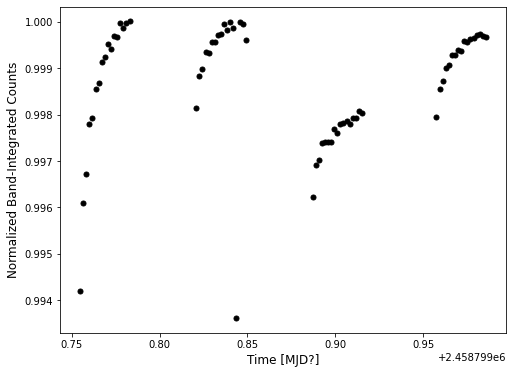

In [7]:
# Plotting our raw broadband light curve
fig, ax = plt.subplots(figsize=(8,6))

# Plotting orbit 1 values
ax.errorbar(time_orbit1, bbnflux_orbit1, yerr=bbnunc_orbit1, 
           c='black', marker='o', ms=5, ls='None')
# Plotting orbit 2 values
ax.errorbar(time_orbit2, bbnflux_orbit2, yerr=bbnunc_orbit2, 
           c='black', marker='o', ms=5, ls='None')
# Plotting orbit 3 values
ax.errorbar(time_orbit3, bbnflux_orbit3, yerr=bbnunc_orbit3, 
           c='black', marker='o', ms=5, ls='None')
# Plotting orbit 4 values
ax.errorbar(time_orbit4, bbnflux_orbit4, yerr=bbnunc_orbit4, 
           c='black', marker='o', ms=5, ls='None')

#ax.legend(loc='lower right', fontsize=10)
ax.set_xlabel('Time [MJD?]', fontsize=12)
ax.set_ylabel('Normalized Band-Integrated Counts', fontsize=12)
plt.savefig('normalized_broadband_lightcurve.png', dpi=350, bbox_inches='tight')
plt.show()

In [8]:
save_data = True
if save_data:

    filename = '/home/matthew/data/hd219666b/reduced_data/broadband_lightcurve.dat'
    file = open(filename, 'w')
    file.write('# Broadband (Band-integrated) Light Curve of HD 219666b Transit \n')
    file.write('# Visit 3, Orbit 1:')
    file.write('# Time [MJD; From HST image header], Normalized Flux, Normalized Flux Uncertainty \n')
    for i, time in enumerate(time_orbit1):
        file.write(str(time_orbit1[i]))
        file.write(' ')
        file.write(str(bbnflux_orbit1[i]))
        file.write(' ')
        file.write(str(bbnunc_orbit1[i]))
        file.write('\n')
    file.write('# Visit 3, Orbit 2:')
    file.write('# Time [MJD; From HST image header], Normalized Flux, Normalized Flux Uncertainty \n')        
    for i, time in enumerate(time_orbit2):
        file.write(str(time_orbit2[i]))
        file.write(' ')
        file.write(str(bbnflux_orbit2[i]))
        file.write(' ')
        file.write(str(bbnunc_orbit2[i]))
        file.write('\n')
    file.write('# Visit 3, Orbit 3:')
    file.write('# Time [MJD; From HST image header], Normalized Flux, Normalized Flux Uncertainty \n')        
    for i, time in enumerate(time_orbit3):
        file.write(str(time_orbit3[i]))
        file.write(' ')
        file.write(str(bbnflux_orbit3[i]))
        file.write(' ')
        file.write(str(bbnunc_orbit3[i]))
        file.write('\n')
    file.write('# Visit 3, Orbit 4:')
    file.write('# Time [MJD; From HST image header], Normalized Flux, Normalized Flux Uncertainty \n')        
    for i, time in enumerate(time_orbit4):
        file.write(str(time_orbit4[i]))
        file.write(' ')
        file.write(str(bbnflux_orbit4[i]))
        file.write(' ')
        file.write(str(bbnunc_orbit4[i]))
        file.write('\n')        
        
    file.close()